# Importing

In [110]:
# base
import pandas as pd
import numpy as np

# metrics and prepocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

# models
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgb

# plots
import seaborn as sns
import matplotlib.pyplot as plt

# optimizers
import optuna
from optuna.pruners import HyperbandPruner
from sklearn.model_selection import KFold

# Data preprocessing

Firstly, we need to upload train and test data, placed in *data.csv* and *test.csv*

In [111]:
data = pd.read_csv('data.csv')
data.head()

,index,kitchen_area,bath_area,other_area,gas,hot_water,central_heating,extra_area,extra_area_count,year,ceil_height,floor_max,floor,total_area,bath_count,extra_area_type_name,district_name,rooms_count,price
0,0,17,34,42.876495,Yes,No,Yes,3,1,2011,3.16,12,4,94.876495,2,balcony,Moskovskij,2,28285348
1,1,17,12,25.487543,Yes,Yes,Yes,11,1,1908,4.68,2,2,58.154210,1,balcony,Nevskij,2,12923063
2,2,22,35,39.041948,No,No,Yes,9,1,1953,3.12,3,2,99.041948,2,balcony,Kirovskij,3,20463247
3,3,11,26,11.646696,No,Yes,Yes,5,0,2004,2.50,15,1,50.313363,2,loggia,Krasnoselskij,0,10517141
4,4,8,14,14.406673,No,No,Yes,18,1,1970,2.50,7,2,42.406673,1,balcony,Krasnoselskij,0,8455506


In [112]:
test_data = pd.read_csv('test.csv')
test_data.head()

,index,kitchen_area,bath_area,other_area,gas,hot_water,central_heating,extra_area,extra_area_count,year,ceil_height,floor_max,floor,total_area,bath_count,extra_area_type_name,district_name,rooms_count
0,0,25,24,11.577599,Yes,Yes,Yes,15,1,1945,2.70,4,2,65.577599,2,balcony,Centralnyj,0
1,1,24,13,28.856040,Yes,Yes,No,13,1,1901,2.50,1,1,70.189373,1,loggia,Kirovskij,2
2,2,14,25,43.275806,Yes,No,Yes,0,1,1941,2.95,3,2,82.275806,2,balcony,Petrogradskij,4
3,3,18,22,11.320209,Yes,Yes,Yes,17,2,1990,3.39,7,2,56.986876,2,loggia,Moskovskij,0
4,4,26,10,20.524394,No,No,Yes,8,1,1938,4.77,3,2,59.191060,1,balcony,Nevskij,0


In [113]:
data.describe()

,index,kitchen_area,bath_area,other_area,extra_area,extra_area_count,year,ceil_height,floor_max,floor,total_area,bath_count,rooms_count,price
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,49999.500000,16.494980,21.485220,28.156113,9.989530,1.001600,1960.126790,3.127614,6.380690,3.687100,69.466156,1.699730,1.471740,1.651210e+07
std,28867.657797,5.761893,8.645616,20.403852,5.777662,0.707377,34.622494,0.807468,3.939299,2.908119,23.010494,0.458378,1.716453,5.977483e+06
min,0.000000,7.000000,7.000000,11.000130,0.000000,0.000000,1900.000000,2.500000,1.000000,1.000000,26.102821,1.000000,0.000000,4.680056e+06
25%,24999.750000,11.000000,14.000000,12.987989,5.000000,1.000000,1930.000000,2.500000,3.000000,2.000000,53.092145,1.000000,0.000000,1.220732e+07
50%,49999.500000,16.000000,21.000000,18.901809,10.000000,1.000000,1960.000000,2.510000,5.000000,3.000000,64.370379,2.000000,1.000000,1.536205e+07
75%,74999.250000,21.000000,29.000000,36.874833,15.000000,2.000000,1990.000000,3.750000,9.000000,5.000000,80.456438,2.000000,2.000000,1.966873e+07
max,99999.000000,26.000000,36.000000,90.999638,20.000000,2.000000,2020.000000,5.000000,23.000000,23.000000,158.715271,2.000000,9.000000,4.440331e+07


In [114]:
numeric = ["kitchen_area", "bath_area", "other_area", "extra_area", "extra_area_count", "year", "ceil_height", "floor_max", "floor", "total_area", "bath_count", "rooms_count"]
categorical = ["gas", "hot_water", "central_heating", "extra_area_type_name", "district_name"]

Let's take a look at the plots

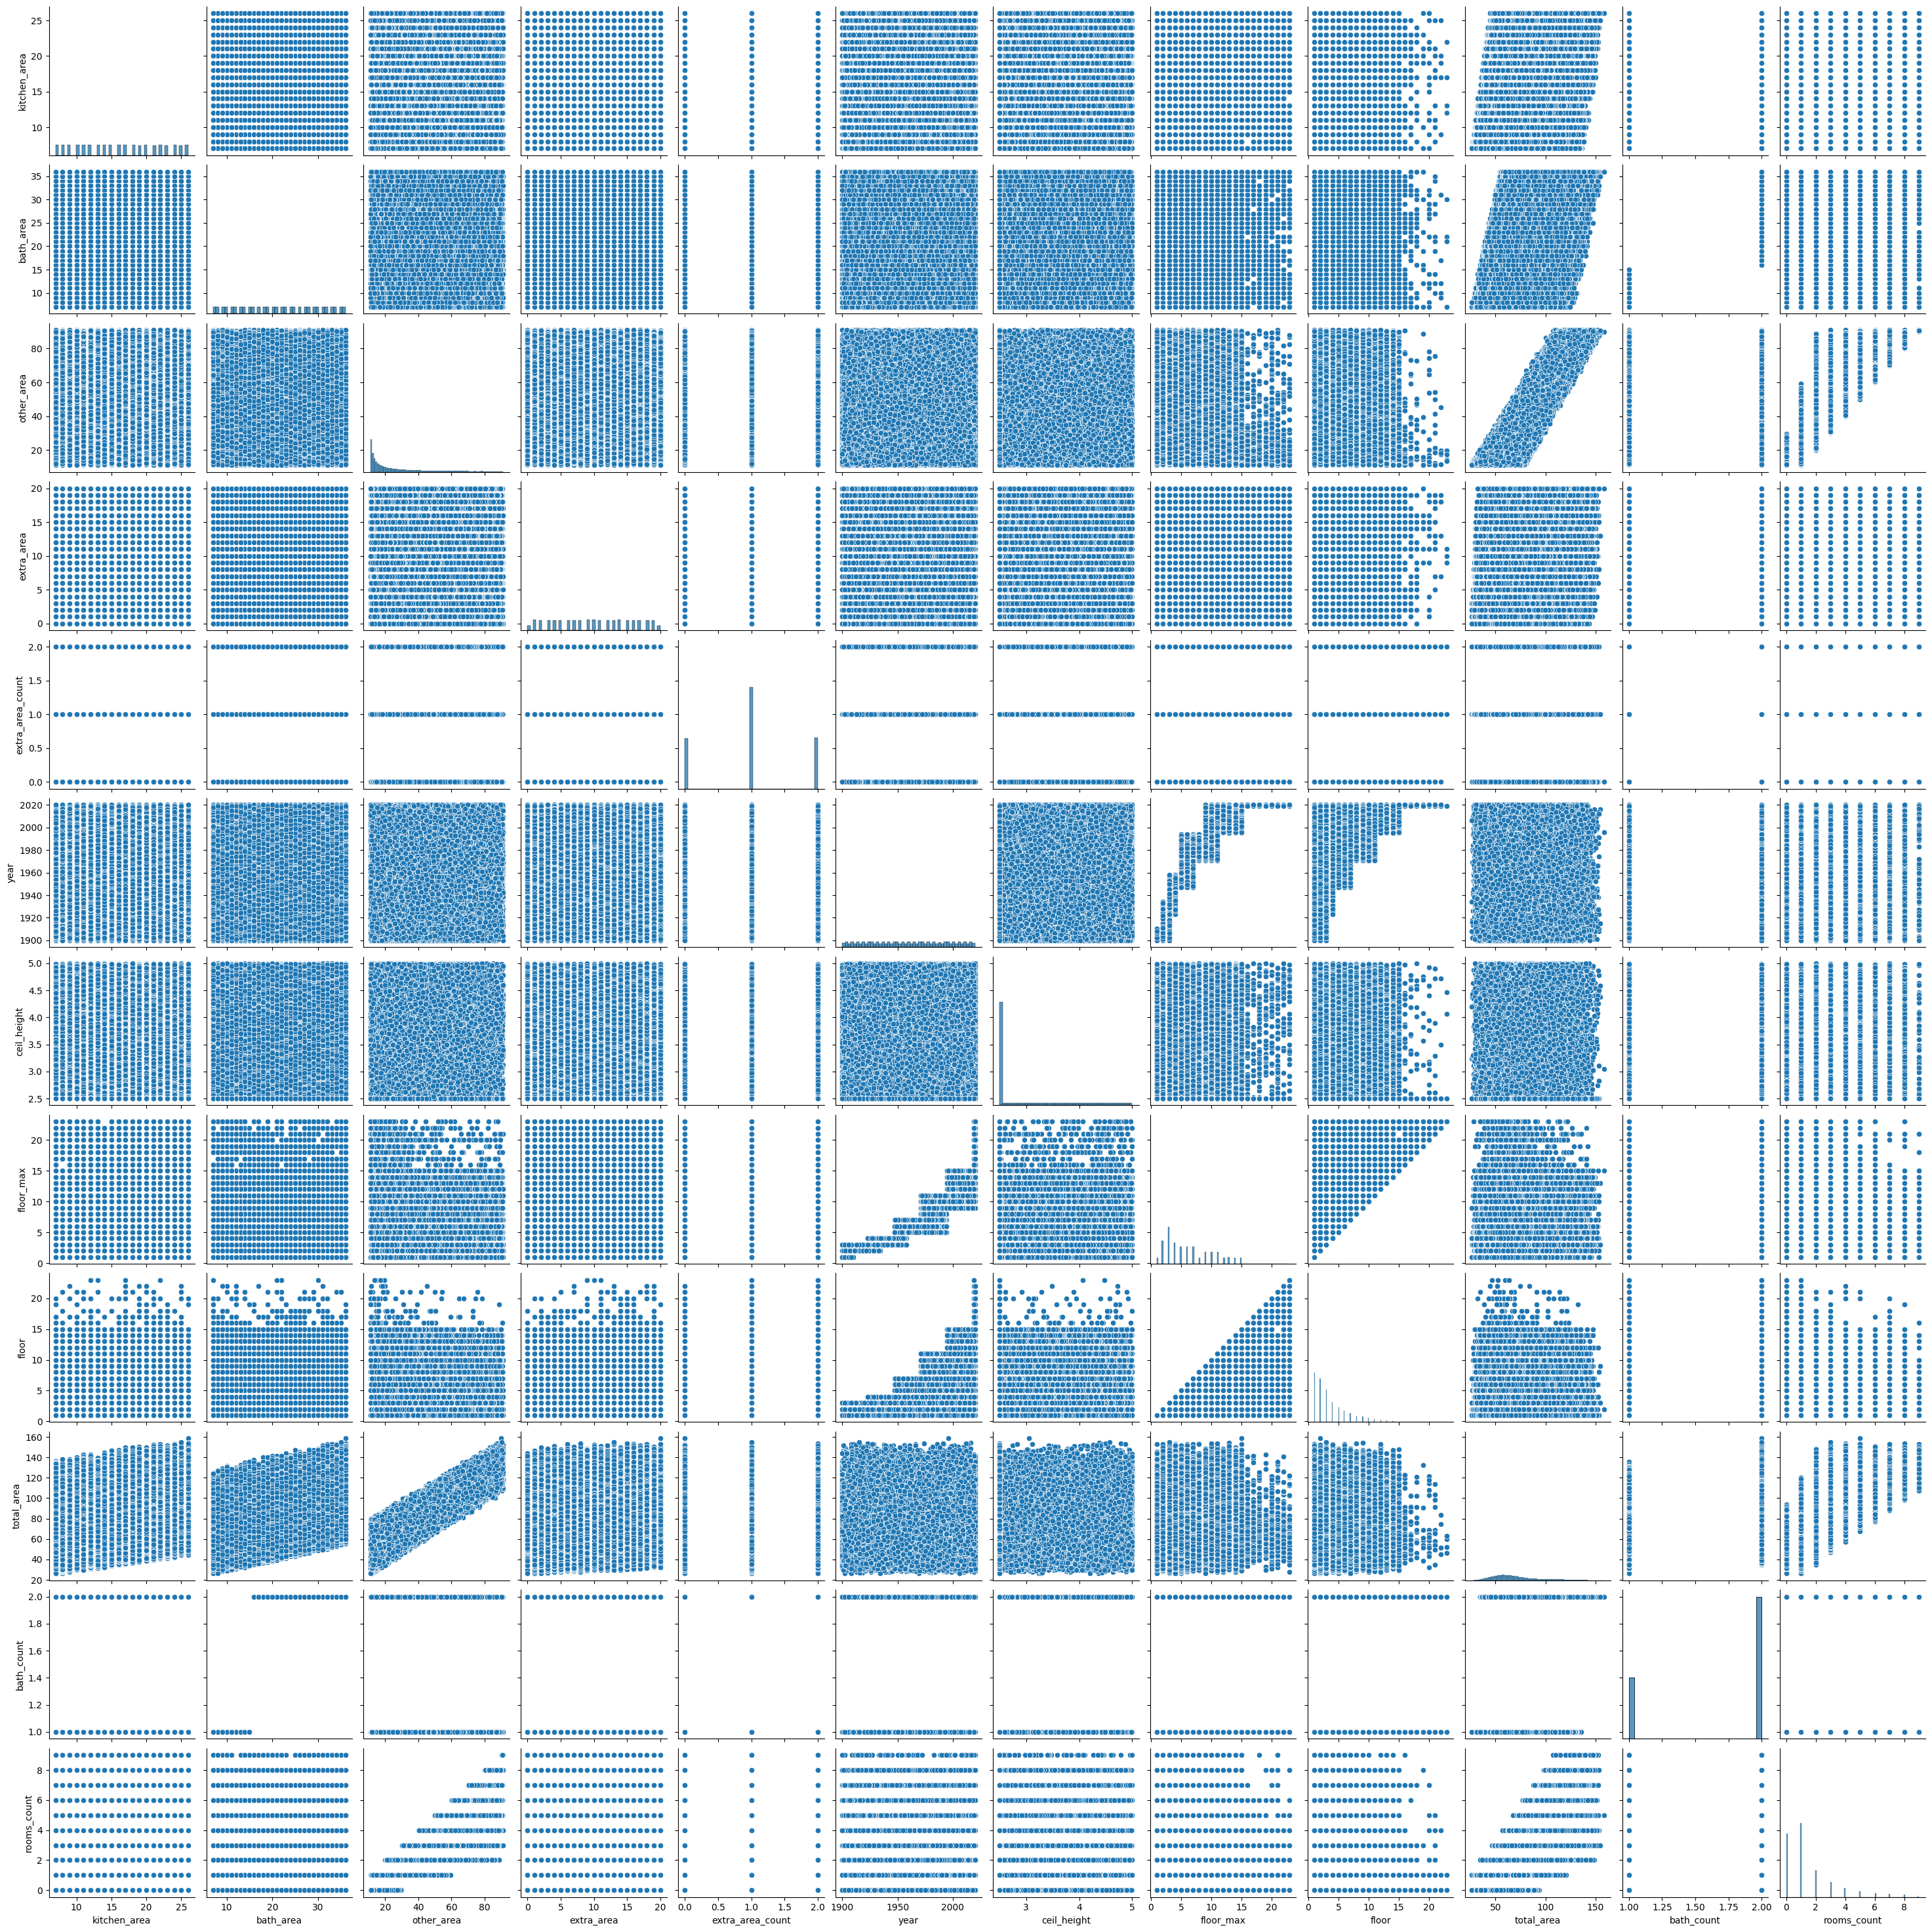

In [115]:
sns.pairplot(data[numeric]);

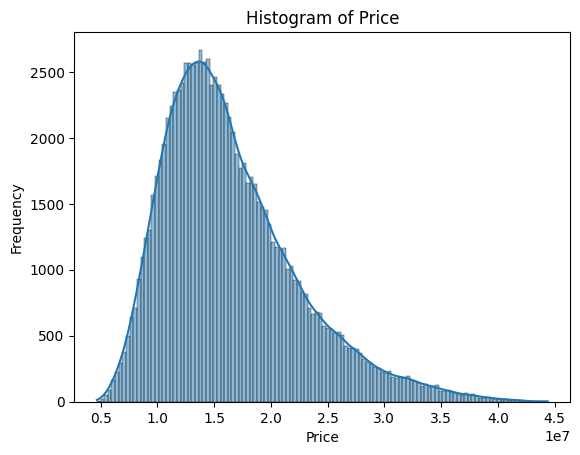

In [116]:
sns.histplot(data=data, x='price', kde=True)
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

The price histogram and histogram of other_area look unbalanced and have heavy tails, so that log-function for them needed

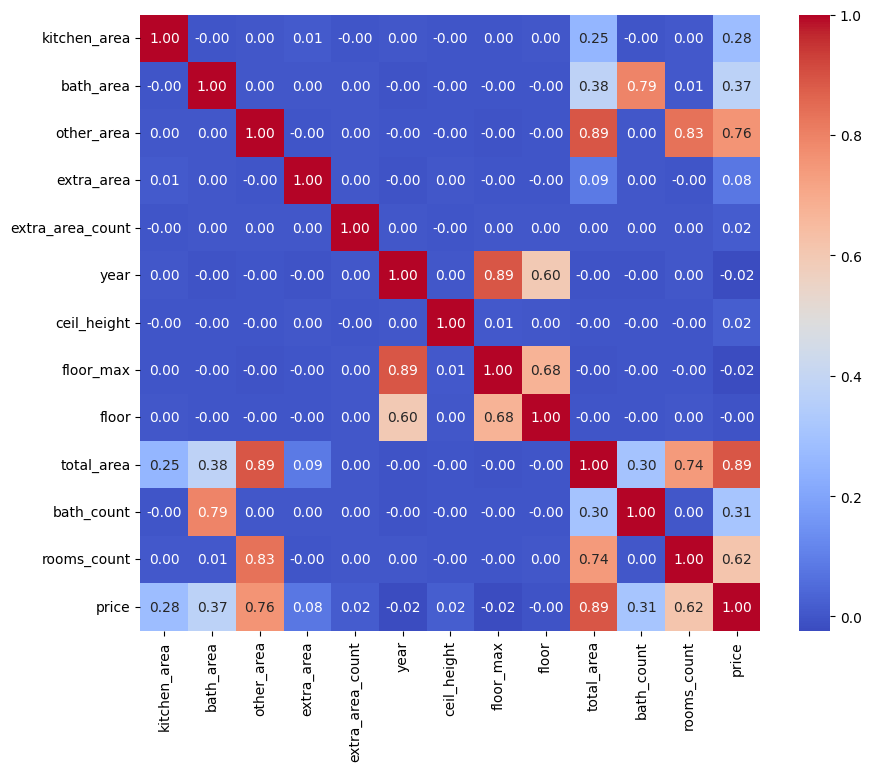

In [117]:
plt.figure(figsize=(10, 8))
sns.heatmap(data[numeric + ["price"]].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

Drop noise making by index column

In [118]:
# drops
data.drop(columns=['index'], inplace=True)
test_data.drop(columns=['index'], inplace=True)
data = data.dropna()

data.head()

,kitchen_area,bath_area,other_area,gas,hot_water,central_heating,extra_area,extra_area_count,year,ceil_height,floor_max,floor,total_area,bath_count,extra_area_type_name,district_name,rooms_count,price
0,17,34,42.876495,Yes,No,Yes,3,1,2011,3.16,12,4,94.876495,2,balcony,Moskovskij,2,28285348
1,17,12,25.487543,Yes,Yes,Yes,11,1,1908,4.68,2,2,58.154210,1,balcony,Nevskij,2,12923063
2,22,35,39.041948,No,No,Yes,9,1,1953,3.12,3,2,99.041948,2,balcony,Kirovskij,3,20463247
3,11,26,11.646696,No,Yes,Yes,5,0,2004,2.50,15,1,50.313363,2,loggia,Krasnoselskij,0,10517141
4,8,14,14.406673,No,No,Yes,18,1,1970,2.50,7,2,42.406673,1,balcony,Krasnoselskij,0,8455506


Making more features will decrease rmse

In [119]:
# add more features
data['living_area'] = data['total_area'] - data['kitchen_area'] - data['bath_area'] - data['other_area']
test_data['living_area'] = test_data['total_area'] - test_data['kitchen_area'] - test_data['bath_area'] - test_data['other_area']

numeric += ['living_area']

In [120]:
# ratio features
data['kitchen_share'] = data['kitchen_area'] / data['total_area']
data['bath_share'] = data['bath_area'] / data['total_area']
data['living_share'] = data['living_area'] / data['total_area']
data['rooms_density'] = data['rooms_count'] / data['total_area']
data['floor_ratio'] = data['floor'] / data['floor_max']

# test data
test_data['kitchen_share'] = test_data['kitchen_area'] / test_data['total_area']
test_data['bath_share'] = test_data['bath_area'] / test_data['total_area']
test_data['living_share'] = test_data['living_area'] / test_data['total_area']
test_data['rooms_density'] = test_data['rooms_count'] / test_data['total_area']
test_data['floor_ratio'] = test_data['floor'] / test_data['floor_max']

numeric += ['kitchen_share', 'bath_share', 'living_share', 'rooms_density', 'floor_ratio']

In [121]:
# age feature
data['age_of_property'] = 2025 - data['year']
test_data['age_of_property'] = 2025 - test_data['year']

numeric += ['age_of_property']

In [122]:
# log features
for c in ['total_area', 'kitchen_area', 'living_area']:
    data[f'log_{c}'] = np.log1p(data[c])
    test_data[f'log_{c}'] = np.log1p(test_data[c])
    numeric += [f'log_{c}']

In [123]:
# x features
data['area_x_floor'] = data['total_area'] * data['floor_ratio']
data['area_x_rooms'] = data['total_area'] * data['rooms_count']
data['kitchen_x_rooms'] = data['kitchen_area'] * data['rooms_count']

# test data
test_data['area_x_floor'] = test_data['total_area'] * test_data['floor_ratio']
test_data['area_x_rooms'] = test_data['total_area'] * test_data['rooms_count']
test_data['kitchen_x_rooms'] = test_data['kitchen_area'] * test_data['rooms_count']

numeric += [
    'area_x_floor', 'area_x_rooms', 'kitchen_x_rooms'
]

In [124]:
data['year'].describe()

count    100000.000000
mean       1960.126790
std          34.622494
min        1900.000000
25%        1930.000000
50%        1960.000000
75%        1990.000000
max        2020.000000
Name: year, dtype: float64

In [125]:
# segment features
data['segment_size'] = pd.cut(
    data['total_area'],
    bins=[0, 40, 60, 80, 120, 200],
    labels=[0,1,2,3,4],
)
data['segment_year'] = pd.cut(
    data['year'],
    bins=[1890, 1945, 1970, 2000, 2015, 2030],
    labels=[0,1,2,3,4],
)

# test data
test_data['segment_size'] = pd.cut(
    test_data['total_area'],
    bins=[0, 40, 60, 80, 120, 200],
    labels=[0,1,2,3,4]
)
test_data['segment_year'] = pd.cut(
    test_data['year'],
    bins=[1890, 1945, 1970, 2000, 2015, 2030],
    labels=[0,1,2,3,4]
)

data['segment_size'] = data['segment_size'].astype('int')
data['segment_year'] = data['segment_year'].astype('int')
test_data['segment_size'] = test_data['segment_size'].astype('int')
test_data['segment_year'] = test_data['segment_year'].astype('int')

numeric += ['segment_size', 'segment_year']

In [126]:
# more categorical features
data['is_old'] = (data['year'] < 1970).astype(int)
data['is_stalin'] = ((data['year'] >= 1930) & (data['year'] <= 1960) & (data['ceil_height'] > 3.1)).astype(int)
data['is_newhouse'] = (data['year'] > 2010).astype(int)
data["is_first_floor"] = (data["floor"] == 1).astype(int)
data["is_top_floor"] = (data["floor"] == data["floor_max"]).astype(int)

# test data
test_data['is_old'] = (test_data['year'] < 1970).astype(int)
test_data['is_stalin'] = ((test_data['year'] >= 1930) & (test_data['year'] <= 1960) & (test_data['ceil_height'] > 3.1)).astype(int)
test_data['is_newhouse'] = (test_data['year'] > 2010).astype(int)
test_data["is_first_floor"] = (test_data["floor"] == 1).astype(int)
test_data["is_top_floor"] = (test_data["floor"] == test_data["floor_max"]).astype(int)

categorical += [
    "is_old", "is_stalin", "is_newhouse", 'is_first_floor', 'is_top_floor'
]

In [127]:
log_vars = [
    "other_area", "floor", "floor_max"
]

In [128]:
for var in log_vars:
    data[var] = np.log1p(data[var])
    test_data[var] = np.log1p(test_data[var])

In [129]:
data.head()

,kitchen_area,bath_area,other_area,gas,hot_water,central_heating,extra_area,extra_area_count,year,ceil_height,...,area_x_floor,area_x_rooms,kitchen_x_rooms,segment_size,segment_year,is_old,is_stalin,is_newhouse,is_first_floor,is_top_floor
0,17,34,3.781379,Yes,No,Yes,3,1,2011,3.16,...,31.625498,189.752990,34,3,3,0,0,1,0,0
1,17,12,3.276675,Yes,Yes,Yes,11,1,1908,4.68,...,58.154210,116.308419,34,1,0,1,0,0,0,1
2,22,35,3.689928,No,No,Yes,9,1,1953,3.12,...,66.027966,297.125845,66,3,1,1,1,0,0,0
3,11,26,2.537396,No,Yes,Yes,5,0,2004,2.50,...,3.354224,0.000000,0,1,3,0,0,0,1,0
4,8,14,2.734801,No,No,Yes,18,1,1970,2.50,...,12.116192,0.000000,0,1,1,0,0,0,0,0


# Making training and test data

In [130]:
feature_cols = numeric + categorical

In [131]:
X, y = data[feature_cols], data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Tests gave that learning and testing on price_per_m2 decreasing rmse by 3k+

In [132]:
y_train = y_train / X_train['total_area']

In [133]:
y_train_log = np.log1p(y_train)

For best results mean target encoding was made

In [134]:
def target_encode_oof(
    X_train, y, X_test, X_val, cat_cols,
    n_splits=5, smoothing=15, noise=0.01
):
    X_tr_enc = X_train.copy()
    X_te_enc = X_test.copy()
    X_val_enc = X_val.copy()

    global_mean = y.mean()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for col in cat_cols:
        oof_mean = np.zeros(len(X_train))
        oof_min = np.zeros(len(X_train))
        oof_max = np.zeros(len(X_train))

        for tr_idx, val_idx in kf.split(X_train):
            X_tr, X_va = X_train.iloc[tr_idx], X_train.iloc[val_idx]
            y_tr = y.iloc[tr_idx]

            stats = y_tr.groupby(X_tr[col]).agg(['mean', 'count', 'min', 'max'])

            smooth_mean = (
                (stats['count'] * stats['mean'] + smoothing * global_mean)
                / (stats['count'] + smoothing)
            )

            oof_mean[val_idx] = X_va[col].map(smooth_mean).fillna(global_mean)
            oof_min[val_idx] = X_va[col].map(stats['min']).fillna(global_mean)
            oof_max[val_idx] = X_va[col].map(stats['max']).fillna(global_mean)

        rng = np.random.default_rng(seed=42)
        oof_mean += noise * rng.standard_normal(len(oof_mean))
        
        X_tr_enc[f'{col}_te'] = oof_mean
        X_tr_enc[f'{col}_min'] = oof_min
        X_tr_enc[f'{col}_max'] = oof_max

        stats = y.groupby(X_train[col]).agg(['mean', 'count', 'min', 'max'])

        smooth_mean = (
            (stats['count'] * stats['mean'] + smoothing * global_mean)
            / (stats['count'] + smoothing)
        )

        for df in [X_te_enc, X_val_enc]:
            df[f'{col}_te'] = df[col].map(smooth_mean).fillna(global_mean)
            df[f'{col}_min'] = df[col].map(stats['min']).fillna(global_mean)
            df[f'{col}_max'] = df[col].map(stats['max']).fillna(global_mean)

        freq = X_train[col].value_counts(normalize=True)
        X_tr_enc[f'{col}_freq'] = X_train[col].map(freq)
        X_te_enc[f'{col}_freq'] = X_test[col].map(freq).fillna(0)
        X_val_enc[f'{col}_freq'] = X_val[col].map(freq).fillna(0)

    X_tr_enc.drop(columns=cat_cols, inplace=True)
    X_te_enc.drop(columns=cat_cols, inplace=True)
    X_val_enc.drop(columns=cat_cols, inplace=True)

    return X_tr_enc, X_te_enc, X_val_enc

In [135]:
cat_cols = categorical

X_train_te, X_test_te, X_val_te = target_encode_oof(
    X_train=X_train,
    y=y_train_log,
    X_test=X_test,
    X_val=test_data,
    cat_cols=cat_cols,
    n_splits=5,
    smoothing=15,
    noise=0.01
)

X_train = X_train_te
X_test = X_test_te
test_data = X_val_te

In [136]:
numeric += [cat + "_freq" for cat in cat_cols]
numeric += [cat + "_min" for cat in cat_cols]
numeric += [cat + "_max" for cat in cat_cols]
numeric += [cat + "_te" for cat in cat_cols]
categorical = []
feature_cols = numeric + categorical

# Parameters search (catboost)

Let's search best parameters for dataset by optuna

In [137]:
mode = 'test'
# mode = 'train'

In [138]:
if mode == 'train':
    def objective_cat(trial):
        params = {
            "depth": trial.suggest_int("depth", 4, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 20, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 5.0),
            "random_strength": trial.suggest_float("random_strength", 0.0, 20.0),
            "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),

            "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 50),
            "border_count": trial.suggest_int("border_count", 32, 255),

            "task_type": "GPU",
            "devices": "0",
            "loss_function": "RMSE",
            "verbose": 0,
            "n_estimators": 600,

            "od_type": "IncToDec",
            "od_wait": 20,
            "cat_features": categorical
        }

        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        rmses = []
        for fold_idx, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
            model = CatBoostRegressor(**params)

            model.fit(
                X_train.iloc[tr_idx], y_train_log.iloc[tr_idx],
                eval_set=(X_train.iloc[val_idx], y_train_log.iloc[val_idx]),
                verbose=False
            )

            pred = model.predict(X_train.iloc[val_idx])
            rmse = root_mean_squared_error(y_train_log.iloc[val_idx], pred)
            rmses.append(rmse)

            trial.report(rmse, step=fold_idx)

            if trial.should_prune():
                raise optuna.TrialPruned()

        return float(np.mean(rmses))

    sampler = optuna.samplers.TPESampler(multivariate=True)
    study_cat = optuna.create_study(direction="minimize", pruner=HyperbandPruner(), sampler=sampler)
    study_cat.optimize(objective_cat, n_trials=500)

    best_cat = study_cat.best_params
    display(best_cat)

elif mode == 'test':
    best_cat = {
        'depth': 4,
        'learning_rate': 0.060730053590420136,
        'l2_leaf_reg': 7.305316249468007,
        'bagging_temperature': 0.5390055701465774,
        'random_strength': 3.2799419269521843,
        'leaf_estimation_iterations': 9,
        'grow_policy': 'SymmetricTree',
        'min_data_in_leaf': 7,
        'border_count': 251
    }

# Parameters search (xgboost)

In [139]:
if mode == 'train':
    def objective_xgb(trial):
        params = {
            "max_depth": trial.suggest_int("max_depth", 3, 10),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 20, log=True),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 20, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),

            "gamma": trial.suggest_float("gamma", 0, 10),
            "min_child_weight": trial.suggest_float("min_child_weight", 1e-3, 50, log=True),

            "n_estimators": 600,
            "tree_method": "hist",
            "device": "cuda",
            "eval_metric": "rmse",
            "verbosity": 0
        }

        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        rmses = []

        for fold_idx, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
            model = xgb.XGBRegressor(**params)

            model.fit(
                X_train.iloc[tr_idx], y_train_log.iloc[tr_idx],
                eval_set=[(X_train.iloc[val_idx], y_train_log.iloc[val_idx])],
                verbose=False
            )

            pred = model.predict(X_train.iloc[val_idx])
            rmse_val = root_mean_squared_error(y_train_log.iloc[val_idx], pred)
            rmses.append(rmse_val)

            trial.report(rmse_val, step=fold_idx)

            if trial.should_prune():
                raise optuna.TrialPruned()

        return float(np.mean(rmses))

    sampler = optuna.samplers.TPESampler(multivariate=True)
    study_xgb = optuna.create_study(direction="minimize", pruner=HyperbandPruner(), sampler=sampler)
    study_xgb.optimize(objective_xgb, n_trials=500)

    best_xgb = study_xgb.best_params
    display(best_xgb)
    
elif mode == 'test':
    best_xgb = {
        'max_depth': 4,
        'learning_rate': 0.07428054736219174,
        'reg_lambda': 0.005589001268332194,
        'reg_alpha': 0.001769296581751625,
        'subsample': 0.5646014194575644,
        'colsample_bytree': 0.8335762341807911,
        'gamma': 0.002251095709566067,
        'min_child_weight': 39.592038080246944
    }

# Parameters search (lgd)

In [140]:
if mode == 'train':
    def objective_lgb(trial):

        params = {
            "num_leaves": trial.suggest_int("num_leaves", 16, 256),
            "max_depth": trial.suggest_int("max_depth", -1, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),

            "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),

            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 100),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-3, 10, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-3, 10, log=True),

            "n_estimators": 3000,
            "objective": "rmse",

            "device": "gpu",
            "verbosity": -1,
        }

        kf = KFold(n_splits=3, shuffle=True, random_state=42)
        rmses = []

        for fold_idx, (tr_idx, val_idx) in enumerate(kf.split(X_train)):
            model = lgb.LGBMRegressor(**params)

            model.fit(
                X_train.iloc[tr_idx], y_train_log.iloc[tr_idx],
                eval_set=[(X_train.iloc[val_idx], y_train_log.iloc[val_idx])],
                eval_metric="rmse",
                callbacks=[
                    lgb.early_stopping(stopping_rounds=50, verbose=False)
                ]
            )

            pred = model.predict(X_train.iloc[val_idx])
            rmse_val = root_mean_squared_error(y_train_log.iloc[val_idx], pred)
            rmses.append(rmse_val)

            trial.report(rmse_val, step=fold_idx)
            
            if trial.should_prune():
                raise optuna.TrialPruned()

        return float(np.mean(rmses))


    sampler = optuna.samplers.TPESampler(multivariate=True)
    study_lgb = optuna.create_study(
        direction="minimize",
        pruner=optuna.pruners.HyperbandPruner(),
        sampler=sampler
    )

    study_lgb.optimize(objective_lgb, n_trials=250)

    best_lgb = study_lgb.best_params
    display(best_lgb)
    
elif mode == 'test':
    best_lgb = {
        'num_leaves': 33,
        'max_depth': 13,
        'learning_rate': 0.017051347988315806,
        'feature_fraction': 0.523340612478275,
        'bagging_fraction': 0.8849526652149885,
        'bagging_freq': 3,
        'min_data_in_leaf': 5,
        'lambda_l1': 0.014563320115407584,
        'lambda_l2': 0.0011335228871428994
    }

# Ensemble

Ensembling models for all the best results (but usual catboost already beats 144 500 rmse)

In [141]:
cat_best = CatBoostRegressor(
    task_type="GPU", devices="0", loss_function="RMSE",
    n_estimators=1_250, verbose=0, **best_cat,
    random_state=42
)

xgb_best = xgb.XGBRegressor(
    device="cuda", eval_metric="rmse", tree_method="hist",
    n_estimators=5_000, verbosity=0, **best_xgb,
    random_state=42, objective="reg:squarederror"
)

lgb_best = lgb.LGBMRegressor(
    n_estimators=20_000, **best_lgb,
    random_state=42, verbosity=0
)

rf = RandomForestRegressor(
    n_estimators=800,
    max_depth=12,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)

estimators = [
    ('catboost', cat_best),
    ('xgboost', xgb_best),
    ('lgb', lgb_best),
    ('rf', rf)
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    passthrough=True,
    cv=5,
    n_jobs=1,
)

stacking_model.fit(X_train[feature_cols], y_train_log)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.523340612478275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.523340612478275
[LightGBM] [Warning] lambda_l1 is set=0.014563320115407584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014563320115407584
[LightGBM] [Warning] lambda_l2 is set=0.0011335228871428994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011335228871428994
[LightGBM] [Warning] bagging_fraction is set=0.8849526652149885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849526652149885
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.523340612478275, colsample_by

,estimators,"[('catboost', ...), ('xgboost', ...), ...]"
,final_estimator,LinearRegression()
,cv,5
,n_jobs,1
,passthrough,True
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [142]:
pred_log_global = stacking_model.predict(X_test[feature_cols])
pred_global = np.expm1(pred_log_global) * X_test['total_area']

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.523340612478275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.523340612478275
[LightGBM] [Warning] lambda_l1 is set=0.014563320115407584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014563320115407584
[LightGBM] [Warning] lambda_l2 is set=0.0011335228871428994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011335228871428994
[LightGBM] [Warning] bagging_fraction is set=0.8849526652149885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849526652149885
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [143]:
root_mean_squared_error(y_test, pred_global)
# 144338.10349938038 <- best

144387.17019850793

# Different models

Mixing that result with different rooms models, because it gives small percent of boost

In [144]:
def room_bucket(rc):
    if rc == 1:
        return 1
    elif rc == 2:
        return 2
    elif rc == 3:
        return 3
    else:
        return 4

X_train["room_group"] = X_train["rooms_count"].apply(room_bucket)
X_test["room_group"] = X_test["rooms_count"].apply(room_bucket)

In [145]:
models = {}

for group in X_train["room_group"].unique():
    mask = X_train["room_group"] == group
    mask_test = X_test["room_group"] == group

    df_train = X_train[feature_cols][mask]
    out_train = y_train_log[mask]

    df_test = X_test[feature_cols][mask_test]
    out_test = np.log1p(y_test[mask_test] / X_test['total_area'][mask_test])

    model = CatBoostRegressor(
        task_type="GPU", devices="0", loss_function="RMSE",
        n_estimators=15_000, verbose=0, **best_cat,
        random_state=42, early_stopping_rounds=100, use_best_model=True
    )

    model.fit(df_train, out_train, eval_set = (df_test, out_test))
    models[group] = model

    print(f"Model for rooms={group} trained")

Model for rooms=1 trained
Model for rooms=4 trained
Model for rooms=3 trained
Model for rooms=2 trained


In [146]:
def predict_price(df_new, models):
    preds = []

    for _, row in df_new.iterrows():
        group = room_bucket(row["rooms_count"])
        model = models.get(group, models[4])

        X_row = row[feature_cols].to_frame().T
        pred_log = model.predict(X_row)[0]
        preds.append(pred_log)

    return np.array(preds)

In [147]:
pred_log_room = predict_price(X_test[feature_cols], models)
pred_room = np.expm1(pred_log_room) * X_test['total_area']

In [148]:
root_mean_squared_error(y_test, pred_room)
# 144706.43927314304 <-- best

145358.73772794555

In [149]:
best_rmse = float('inf')
for a in np.arange(0, 1, 0.001):
    pred_log = a * pred_log_room + (1 - a) * pred_log_global
    pred = np.expm1(pred_log) * X_test['total_area']
    rmse = root_mean_squared_error(y_test, pred)
    if rmse < best_rmse:
        best_rmse = min(rmse, best_rmse)
        best_a = a
    print(f"a = {a}: rmse -> {rmse}")
print(f"\n best -> {best_a} with rmse -> {best_rmse}")
# 144291.72086748978 <- best

a = 0.0: rmse -> 144387.17019850793
a = 0.001: rmse -> 144386.66992643007
a = 0.002: rmse -> 144386.17260510233
a = 0.003: rmse -> 144385.67823455753
a = 0.004: rmse -> 144385.1868148276
a = 0.005: rmse -> 144384.69834594568
a = 0.006: rmse -> 144384.2128279428
a = 0.007: rmse -> 144383.73026085098
a = 0.008: rmse -> 144383.25064470264
a = 0.009000000000000001: rmse -> 144382.7739795286
a = 0.01: rmse -> 144382.30026536016
a = 0.011: rmse -> 144381.82950222862
a = 0.012: rmse -> 144381.36169016475
a = 0.013000000000000001: rmse -> 144380.89682919977
a = 0.014: rmse -> 144380.4349193639
a = 0.015: rmse -> 144379.9759606876
a = 0.016: rmse -> 144379.51995320097
a = 0.017: rmse -> 144379.0668969343
a = 0.018000000000000002: rmse -> 144378.61679191721
a = 0.019: rmse -> 144378.16963817956
a = 0.02: rmse -> 144377.72543575065
a = 0.021: rmse -> 144377.28418466036
a = 0.022: rmse -> 144376.84588493727
a = 0.023: rmse -> 144376.41053661038
a = 0.024: rmse -> 144375.9781397088
a = 0.025: rmse 

# Forming submit

In [150]:
pred_log_room = predict_price(test_data[feature_cols], models)
pred_log_global = stacking_model.predict(test_data[feature_cols])
res_log = best_a * pred_log_room + (1 - best_a) * pred_log_global
final = np.expm1(res_log) * test_data['total_area']

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] feature_fraction is set=0.523340612478275, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.523340612478275
[LightGBM] [Warning] lambda_l1 is set=0.014563320115407584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014563320115407584
[LightGBM] [Warning] lambda_l2 is set=0.0011335228871428994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011335228871428994
[LightGBM] [Warning] bagging_fraction is set=0.8849526652149885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8849526652149885
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [151]:
d = pd.DataFrame({
    "index": np.arange(len(final)),
    "price": final
})

In [152]:
d.describe()

,index,price
count,100000.000000,1.000000e+05
mean,49999.500000,1.649877e+07
std,28867.657797,5.957968e+06
min,0.000000,4.610988e+06
25%,24999.750000,1.221631e+07
50%,49999.500000,1.534794e+07
75%,74999.250000,1.967822e+07
max,99999.000000,4.617234e+07


In [153]:
d.to_csv("out.csv", index=False)